# $t$-distributed stochastic neighbor embedding

If you are one of thousands who use $t$-SNE for dimensionality reduction on a daily basis, but still haven't read the original paper, you found the right place, because here we implement the orgininal $t$-SNE algorithm from van der Maaten's [paper](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).

$t$-SNE find an embedding of a data set $\mathbf{x}_i \in \mathbb{R}^p$, $i \in \{1, \dots , n\}$, into a lower dimensional space $\mathbf{y}_i \in \mathbb{R}^q$ with $q \ll p$.It does so by minimizing the Kullback-Leibler divergence of two probability tables
$$
\sum_i \sum _j p_{j  i} \log \frac{p_{j  i}}{q_{j i}},
$$

where $p_{ji}= \frac{p_{j \mid i} + p_{i \mid j}}{2n}$, $p_{j \mid i}$ are $i$ conditional random walk probabilities that $\mathbf{x}_i$ would pick $\mathbf{x}_j$ as neighbor with probability 

$$ p_{j \mid i} = \frac{\exp \left( -|| \mathbf{x}_i - \mathbf{x}_j || / 2\sigma_i^2 \right) }{\sum_{i \ne k} \exp \left( -|| \mathbf{x}_i - \mathbf{x}_j || / 2\sigma_i^2 \right) }
$$

and $q_{j i}$ are probabilities that the same points would pick each other as neighbors in the *lower* dimensional space which we want to construct:

$$
q_{j i} = \frac{\left( 1 + || \mathbf{y}_i - \mathbf{y}_j || \right)^{-1} }{\sum_{l \ne k} \left( 1 + || \mathbf{y}_i - \mathbf{y}_j || \right)^{-1}}
$$

(note the nominator in this case does not sum over the same indicies as above which makes it symmetric). Look for more details in the paper.

Let's test this with the iris data.

In [1]:
library(kernlab)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘dplyr’ was built under R version 3.5.1”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::alpha() masks kernlab::alpha()
✖ purrr::cross()   masks kernlab::cross()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


In [2]:
X <- as.matrix(iris[,1:4])

To compute the kernels, we define a `cov` function.

In [3]:
cov <- function(X, rbf, sigmas=1) {
    K <- -as.matrix(dist(X))^2
    K <- apply(K, 2, function(i) i / sigmas)
    K <- exp(K)
    diag(K) <- 0
    K
}

In [4]:
cov(X)[1:5, 1:5]

,1,2,3,4,5
1,0.0000000,0.7482636,0.7710516,0.6570468,0.9801987
2,0.7482636,0.0000000,0.9139312,0.8958341,0.6907343
3,0.7710516,0.9139312,0.0000000,0.9417645,0.7710516
4,0.6570468,0.8958341,0.9417645,0.0000000,0.6570468
5,0.9801987,0.6907343,0.7710516,0.6570468,0.0000000


The Gaussian kernel is just the `cov` of above and made row-stochastic:

In [5]:
gaussians <- function(X, rbf, sigmas)
{
    K <- cov(X, rbf, sigmas)
    sweep(K, 1, rowSums(K), "/")
}

In [6]:
gaussians(X, rbf, 1)[1:5, 1:5]

,1,2,3,4,5
1,0.00000000,0.02026183,0.02087890,0.01779182,0.02654228
2,0.02295771,0.00000000,0.02804061,0.02748536,0.02119263
3,0.02311743,0.02740120,0.00000000,0.02823569,0.02311743
4,0.02101706,0.02865519,0.03012438,0.00000000,0.02101706
5,0.02696675,0.01900315,0.02121280,0.01807635,0.00000000


To compute a target Perplexity as in the paper

In [7]:
perplexity <- function(X, sigma, idx)
{
    gau <- gaussians(X, rbf, sigma)[idx, -idx]
    lo <- log2(gau)
    idx <- is.finite(lo)
    per <- 2^(- sum(gau[idx] * lo[idx]))
    per
}

Binary search for the sigmas

In [8]:
sigmas <- function(X, target) 
{
    sigs <- rep(1, nrow(X))
    for (ps in seq(nrow(X)))
    {
        low <- 0
        up <- 100
        for (i in seq(100))
        {
            mid <- (low + up) / 2
            val <- perplexity(X, mid, ps)
            if (val > target) up <- mid
            else low <- mid
            if (abs(val - target) < 0.01) break
        }
        sigs[ps] <- mid
    }
    
    sigs
}

In [9]:
sigs <- sigmas(X, 50)

To compute the $t$ kernel (if that's a thing) we compute the negative logarithm of the `cov`, add invert it.

In [64]:
students <- function(X, rbf)
{
    K <- cov(X, rbf)
    K <- 1 / (1 - log(K))
    diag(K) <- 0
    K[!which(lower.tri(K))] <- 0
    K <- K / apply(K, 1, sum)
    K
}

In [67]:
p <- gaussians(X, rbf, sigs)
p <- (p + t(p)) / (2 * nrow(X)) 

Learning rate

In [68]:
eta <- .5

Define gradient as in the paper:

In [69]:
gradient <- function(p, q, y) 
{
    4 * do.call("rbind", lapply(seq(nrow(p)), function(i) {
        pq <- p[i, ] - q[i, ]
        yi <- y[i,] - y
        t <- 1 + apply(yi, 1, function(s) sum(s^2))
        apply(pq * yi / t, 2, sum)
    }))
}

Actual $t$-SNE algorithm as in the paper:

In [70]:
y <- matrix(rnorm(nrow(X) * 2, 0, 10e-3), nrow(X))
q <- students(X, rbf)
for (t in seq(1000))
{
    q <- students(y, rbf)
    y <- y + eta * gradient(p, q, y)
}

In [71]:
options(repr.plot.height=3)

And plot the results:

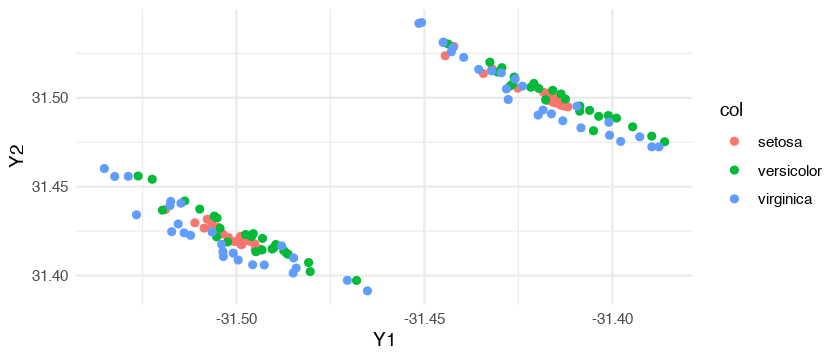

In [72]:
data.frame(Y1=y[,1], Y2=y[,2], col=iris$Species) %>%
    ggplot() +
    geom_point(aes(Y1, Y2, col=col)) +
    theme_minimal()

That looks great. Probably a bug somewhere above.